In [1]:
from fastai.vision.all import *
import pandas as pd
import os

In [2]:
# Define the paths
dir_path = 'data/images/'
train_path = 'data/images/train/'
test_path = 'data/images/'  # Adjust the path if needed

In [3]:
# Define classes
classes = ['0', '1']

# Define the DataBlock with improved data augmentation
roads = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.2),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(460, min_scale=0.75),
    batch_tfms=[
        *aug_transforms(size=224, max_warp=0, flip_vert=True, max_zoom=1.2, max_lighting=0.4, max_rotate=30),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [4]:
# Load the training data
dls = roads.dataloaders(train_path, bs=32)

# Initialize and train the model
learn = vision_learner(dls, resnet50, pretrained=True, metrics=[accuracy, error_rate]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Giles/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:19<00:00, 5.27MB/s]


In [5]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.784710,0.459051,0.837267,0.162733,03:22
1,0.588762,0.271872,0.888199,0.111801,03:16
2,0.453187,0.257572,0.903106,0.096894,03:26
3,0.372057,0.221488,0.918012,0.081988,04:09
4,0.350778,0.192797,0.926708,0.073292,03:50


c:\Users\Giles\miniconda3\envs\vision\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [6]:
# Confirm training accuracy
from sklearn.metrics import accuracy_score

predictions, targets = learn.get_preds(ds_idx=1)
accuracy = accuracy_score(targets, predictions.argmax(dim=-1))
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9267080745341615


In [9]:
# Save the model
learn.save('saved-3')

Path('models/saved-3.pth')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.295029,0.140122,0.944099,0.055901,04:33
1,0.254968,0.211292,0.930435,0.069565,04:42
2,0.243135,0.085502,0.968944,0.031056,04:35
3,0.174720,0.072916,0.975155,0.024845,04:26
4,0.143844,0.128060,0.942857,0.057143,04:35
5,0.112837,0.064755,0.981366,0.018634,04:27
6,0.092913,0.063359,0.975155,0.024845,04:23
7,0.066681,0.033519,0.987578,0.012422,04:33
8,0.046814,0.036528,0.987578,0.012422,04:19
9,0.044687,0.036033,0.987578,0.012422,04:34


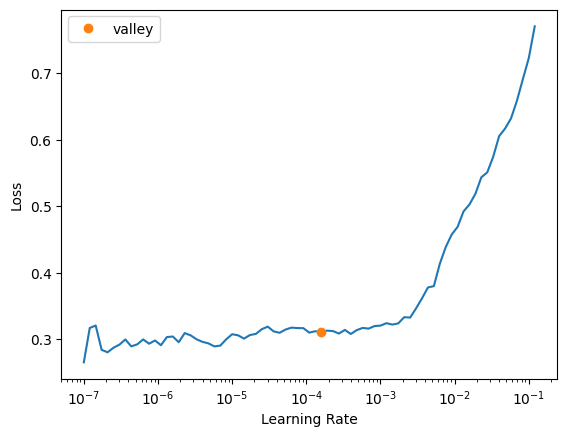

In [10]:
# Fine-tune the model with learning rate finder
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(10, lr_max=slice(1e-4, 1e-3))

[('0', '1', 5), ('1', '0', 5)]


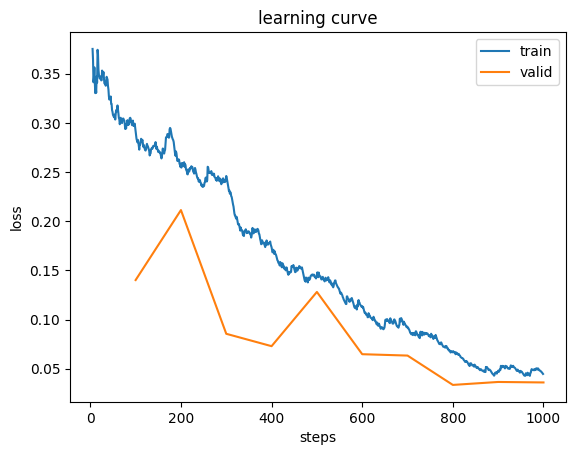

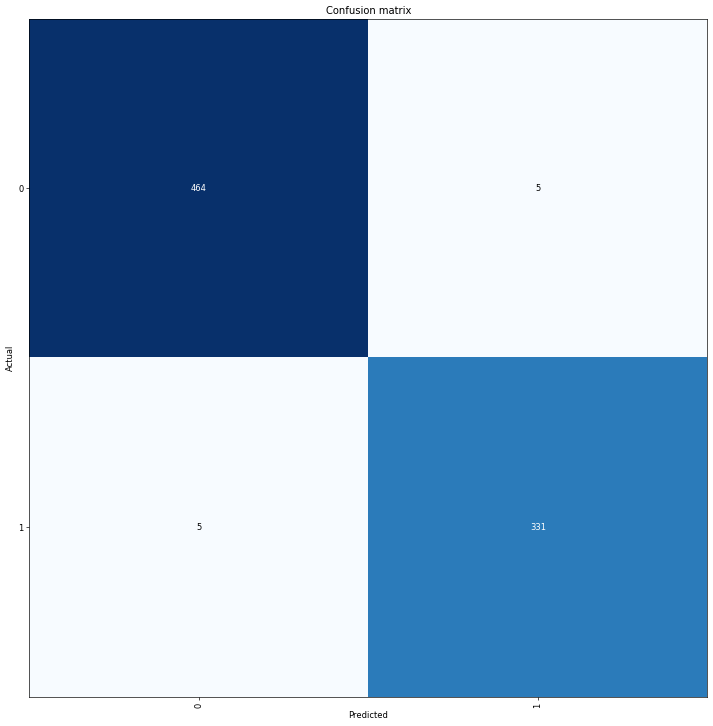

In [11]:
# Plot the loss
learn.recorder.plot_loss()

# Interpret the results
results = ClassificationInterpretation.from_learner(learn)
results.plot_confusion_matrix(figsize=(12, 12), dpi=60)
print(results.most_confused(min_val=3))

In [12]:
# Load the test data
test_ids = pd.read_csv("data/test_ids_only.csv")['Image_ID'].tolist()  # Assuming the CSV has a column named 'Image_ID'

# Append .jpg extension and prepend the base path to each filename
test_files = [os.path.join(test_path, f"{img_id}.jpg") for img_id in test_ids]

In [13]:
# Check if test_files list is empty
if not test_files:
    raise ValueError("No JPG files found in the test set. Please check the file paths and ensure the test CSV contains JPG filenames.")

# Create a DataLoader for the test set
try:
    test_dl = learn.dls.test_dl(test_files)
except IndexError as e:
    raise IndexError("An error occurred while creating the test DataLoader. Check if the files exist and are accessible.") from e

In [15]:
# Make predictions on the test set (getting probabilities)
preds, _ = learn.get_preds(dl=test_dl)
probs = preds.softmax(dim=-1)[:, 1]  # Assuming the second column is the probability of observing a pothole

# Create the submission DataFrame
submission = pd.DataFrame({
    'Image_ID': test_ids,  # Use the original image IDs without the .jpg extension
    'Probability': probs.numpy()
})

# Save the submission DataFrame to a CSV file
submission_file = 'submission_3.csv'
submission.to_csv(submission_file, index=False)
print("Submission CSV created successfully!")


Submission CSV created successfully!
